In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

## Credit VaR computation

In [34]:
interest = pd.read_excel('CreditVaR_data.xlsx', sheet_name='interest', index_col=0, header=0, skiprows=1)
transition = pd.read_excel('CreditVaR_data.xlsx', sheet_name='transition', index_col=0, header=0, skiprows=1)

accump = np.cumsum(np.fliplr(transition.values), axis=1)
accump = accump / 100

thresholds = norm.ppf(accump, 0, 1)
thresholds[:, -1] = np.inf
thresholds_df = pd.DataFrame(thresholds, index=transition.index, columns=transition.columns)
thresholds_df.iloc[:, :] = np.fliplr(thresholds_df.values)

np.round(thresholds_df,2)

rows_A = thresholds_df.loc['A']
rows_BBB = thresholds_df.loc['BBB']

rows_A_upper = rows_A.copy()
rows_BBB_upper = rows_BBB.copy()

rows_A_lower = rows_A.shift(-1, fill_value=-np.inf)  
rows_BBB_lower = rows_BBB.shift(-1, fill_value=-np.inf)  

default_lower_bound = -11100000000000000000

rows_A_lower['Default'] = default_lower_bound
rows_BBB_lower['Default'] = default_lower_bound
print("Upper Bounds for 'A':\n", rows_A_upper)
print("Lower Bounds for 'A':\n", rows_A_lower)
print("Upper Bounds for 'BBB':\n", rows_BBB_upper)
print("Lower Bounds for 'BBB':\n", rows_BBB_lower)

Upper Bounds for 'A':
 AAA             inf
AA         3.121389
A          1.984501
BBB       -1.507042
BB        -2.300852
B         -2.716381
CCC       -3.194651
Default   -3.238880
Name: A, dtype: float64
Lower Bounds for 'A':
 AAA        3.121389e+00
AA         1.984501e+00
A         -1.507042e+00
BBB       -2.300852e+00
BB        -2.716381e+00
B         -3.194651e+00
CCC       -3.238880e+00
Default   -1.110000e+19
Name: A, dtype: float64
Upper Bounds for 'BBB':
 AAA             inf
AA         3.540084
A          2.696844
BBB        1.530068
BB        -1.493142
B         -2.178081
CCC       -2.747781
Default   -2.911238
Name: BBB, dtype: float64
Lower Bounds for 'BBB':
 AAA        3.540084e+00
AA         2.696844e+00
A          1.530068e+00
BBB       -1.493142e+00
BB        -2.178081e+00
B         -2.747781e+00
CCC       -2.911238e+00
Default   -1.110000e+19
Name: BBB, dtype: float64


In [35]:
correlation = 0.3
mean = [0, 0]  
cov = [[1, correlation], [correlation, 1]] 

joint_prob_matrix = pd.DataFrame(0, index=rows_BBB_upper.index, columns=rows_A_upper.index)

for i in range(len(rows_BBB_upper)):
    for j in range(len(rows_A_upper)):
        lower_bound = [rows_BBB_lower.iloc[i], rows_A_lower.iloc[j]]
        upper_bound = [rows_BBB_upper.iloc[i], rows_A_upper.iloc[j]]

        probability = multivariate_normal.cdf(upper_bound, mean=mean, cov=cov) \
                    - multivariate_normal.cdf([lower_bound[0], upper_bound[1]], mean=mean, cov=cov) \
                    - multivariate_normal.cdf([upper_bound[0], lower_bound[1]], mean=mean, cov=cov) \
                    + multivariate_normal.cdf(lower_bound, mean=mean, cov=cov)

        joint_prob_matrix.iloc[i, j] = probability  
        
joint_prob_matrix = (joint_prob_matrix)

print(joint_prob_matrix)

                  AAA        AA         A           BBB            BB  \
AAA      3.805031e-06  0.000034  0.000162  5.375819e-07  2.686417e-08   
AA       3.202183e-05  0.000382  0.002866  1.884728e-05  1.139197e-06   
A        2.310957e-04  0.003936  0.054440  8.126968e-04  6.285623e-05   
BBB      6.291832e-04  0.018097  0.796914  4.552869e-02  5.739969e-03   
BB       3.519469e-06  0.000222  0.044650  6.431951e-03  1.105841e-03   
B        3.377456e-07  0.000027  0.009276  1.824684e-03  3.583626e-04   
CCC      1.913495e-08  0.000002  0.000905  2.168948e-04  4.648258e-05   
Default  1.793389e-08  0.000002  0.001287  3.657028e-04  8.532265e-05   

                    B           CCC       Default  
AAA      4.997084e-09  1.165163e-10  4.733600e-10  
AA       2.376804e-07  6.073117e-09  2.619176e-08  
A        1.526332e-05  4.394428e-07  2.060585e-06  
BBB      1.915983e-03  7.056764e-05  4.045440e-04  
BB       4.464735e-04  1.881412e-05  1.216023e-04  
B        1.579992e-04  7.09133

In [36]:
bond_data = pd.read_excel('CreditVaR_data.xlsx', sheet_name='bonds', index_col=0,header=0)
bond_data['Maturity'] = bond_data['Maturity'].astype(int)


def calculate_discount_rate(interest_rate, year):
    return 1 / ((1 + interest_rate/100) ** year)

discount_rates = {}
for year in range(1, 5):
    discount_rates[year] = {}
    for rating in interest.index:  
        interest_rate = interest.loc[rating, f'Year {year}'] 
        discount_rates[year][rating] = calculate_discount_rate(interest_rate, year)


discount_factors_df = pd.DataFrame(discount_rates)

discount_factors_df.insert(0, 'Year 0', 1)

In [37]:
def calculate_bond_price(coupon_rate, maturity, discount_factors, face_value):
    coupon_rate = float(coupon_rate)

    maturity = int(maturity)

    coupon_payments = [coupon_rate] * maturity

    coupon_payments[-1] += face_value

    discounted_cash_flows = [payment * factor for payment, factor in zip(coupon_payments, discount_factors)]

    present_value = sum(discounted_cash_flows)

    return present_value

In [38]:
bond_ids = [1, 2]

bond_prices = {}
for bond_id in bond_ids:
    bond_prices[bond_id] = {}
    bond_row = bond_data.loc[bond_id]
    coupon_rate = bond_row['CR']
    maturity = bond_row['Maturity']
    face_value = 100  
    for rating in interest.index:
        discount_factors_rating = discount_factors_df.loc[rating]
        bond_prices[bond_id][rating] = calculate_bond_price(coupon_rate, maturity, discount_factors_rating, face_value)


bond_prices_df = pd.DataFrame(bond_prices)

recovery_rates = {}
for bond_id in bond_ids:
    recovery_rate = bond_data.loc[bond_id, 'R_mean']
    recovery_rates[bond_id] = recovery_rate

bond_prices_df.loc['Default'] = recovery_rates

print(bond_prices_df)

                  1           2
AAA      109.352908  106.588062
AA       109.172371  106.492912
A        108.642992  106.304414
BBB      107.530944  105.642643
BB       102.006386  103.151464
B         98.085913  101.391549
CCC       83.625791   88.713413
Default   51.130000   51.130000


In [39]:
def calculate_portfolio_value(bond_prices_df):
    ratings = bond_prices_df.index

    portfolio_values = pd.DataFrame(index=ratings, columns=ratings)

    for rating1 in ratings:
        for rating2 in ratings:
            bond1_price = bond_prices_df.loc[rating1, 1]  
            bond2_price = bond_prices_df.loc[rating2, 2]  

            portfolio_values.at[rating1, rating2] = bond1_price + bond2_price

    return portfolio_values

portfolio_values = calculate_portfolio_value(bond_prices_df)
print(portfolio_values)

                AAA          AA           A         BBB          BB  \
AAA       215.94097   215.84582  215.657322  214.995551  212.504372   
AA       215.760433  215.665283  215.476785  214.815014  212.323834   
A        215.231054  215.135904  214.947406  214.285635  211.794456   
BBB      214.119006  214.023856  213.835358  213.173587  210.682407   
BB       208.594447  208.499298  208.310799  207.649028  205.157849   
B        204.673975  204.578825  204.390327  203.728556  201.237377   
CCC      190.213853  190.118703  189.930205  189.268434  186.777255   
Default  157.718062  157.622912  157.434414  156.772643  154.281464   

                  B         CCC     Default  
AAA      210.744457  198.066321  160.482908  
AA        210.56392  197.885784  160.302371  
A        210.034541  197.356405  159.772992  
BBB      208.922493  196.244357  158.660944  
BB       203.397934  190.719799  153.136386  
B        199.477462  186.799326  149.215913  
CCC       185.01734  172.339204  134.7

In [10]:
joint_probabilities_aligned = joint_prob_matrix.loc[portfolio_values.index, portfolio_values.columns]

mean_portfolio_value = (joint_probabilities_aligned * portfolio_values).sum().sum()
print(f"Mean Portfolio Value: ${mean_portfolio_value}")

values_flat = portfolio_values.values.flatten()
probabilities_flat = joint_probabilities_aligned.values.flatten()


value_prob_df = pd.DataFrame({
    'Value': values_flat,
    'Probability': probabilities_flat
})

value_prob_df.sort_values('Value', inplace=True)

value_prob_df['Cumulative Probability'] = value_prob_df['Probability'].cumsum()


below_1_percent = value_prob_df[value_prob_df['Cumulative Probability'] < 0.01]

if not below_1_percent.empty:
    critical_value_1_percent = below_1_percent.iloc[-1]['Value']  
    print("1% Critical Value:", critical_value_1_percent)
else:
    print("No values are below the 1% cumulative probability threshold.")

VaR = mean_portfolio_value - critical_value_1_percent
print(f"Credit VaR at 99% Confidence: ${VaR}")

Mean Portfolio Value: $213.27082474478433
1% Critical Value: 203.72855587214553
Credit VaR at 99% Confidence: $9.5422688726388


## Credit VaR computation through simulations

In [27]:
coeff_Vivendi_T = 0.4
coeff_Vivendi_L = 0.2
coeff_GM_C = 0.9
correlation= 0.3
var_T = var_L = var_C = 1

var_epsilon_Vivendi = 1 - (coeff_Vivendi_T**2 * var_T + coeff_Vivendi_L**2 * var_L + 2* coeff_Vivendi_T*coeff_Vivendi_L*correlation)
var_epsilon_GM = 1 - (coeff_GM_C**2 * var_C)

print("Standard deviation of specific risk for Vivendi:", np.sqrt(var_epsilon_Vivendi).round(4))
print("Standard deviation of specific risk for GM:", np.sqrt(var_epsilon_GM).round(4))

Standard deviation of specific risk for Vivendi: 0.8672
Standard deviation of specific risk for GM: 0.4359


In [28]:
n_simulations = 100000

corr_matrix = np.array([
    [1, 0.3, 0.1],  # T correlated with L and C
    [0.3, 1, 0.2],  # L correlated with T and C
    [0.1, 0.2, 1.0]   # C correlated with T and L
])

mean_factors = [0, 0, 0]  
cov_factors = corr_matrix  

factors = np.random.multivariate_normal(mean_factors, cov_factors, size=n_simulations)

sigma_epsilon_Vivendi = np.sqrt(var_epsilon_Vivendi)
sigma_epsilon_GM = np.sqrt(var_epsilon_GM)

epsilon_Vivendi = np.random.normal(0, sigma_epsilon_Vivendi, n_simulations)
epsilon_GM = np.random.normal(0, sigma_epsilon_GM, n_simulations)

r_Vivendi = 0.4 * factors[:, 0] + 0.2 * factors[:, 1] + epsilon_Vivendi  # 0.4T + 0.2L + εViv
r_GM = 0.9 * factors[:, 2] + epsilon_GM  # 0.9C + εGM


returns_df = pd.DataFrame({
    'r_Vivendi': r_Vivendi,
    'r_GM': r_GM
})

print("\nSimulated returns for Vivendi and GM:\n",returns_df.head(10))


Simulated returns for Vivendi and GM:
    r_Vivendi      r_GM
0  -0.891325 -0.904341
1   1.971829  0.990708
2  -1.422823 -0.232530
3   0.511249  0.995084
4   1.662564 -0.706989
5  -0.238865 -1.192879
6  -0.722039  0.607993
7  -0.268570 -0.656767
8   0.884400 -1.450783
9  -1.138852 -1.038756


In [29]:
bond_prices_df = pd.DataFrame({
    'AAA': [109.352908, 106.588062],
    'AA': [109.172371, 106.492912],
    'A': [108.642992, 106.304414],
    'BBB': [107.530944, 105.642643],
    'BB': [102.006386, 103.151464],
    'B': [98.085913, 101.391549],
    'CCC': [83.625791, 88.713413],
    'Default': [51.130000, 51.130000]
}, index=[1, 2])

rows_A = {'AAA': [float('inf'), 3.121389], 'AA': [3.121389, 1.984501], 'A': [1.984501, -1.507042],
          'BBB': [-1.507042, -2.300852], 'BB': [-2.300852, -2.716381], 'B': [-2.716381, -3.194651],
          'CCC': [-3.194651, -3.238880], 'Default': [-3.238880, float('-inf')]}

rows_BBB = {'AAA': [float('inf'), 3.540084], 'AA': [3.540084, 2.696844], 'A': [2.696844, 1.530068],
            'BBB': [1.530068, -1.493142], 'BB': [-1.493142, -2.178081], 'B': [-2.178081, -2.747781],
            'CCC': [-2.747781, -2.911238], 'Default': [-2.911238, float('-inf')]}

bond_returns_df = pd.DataFrame(index=bond_prices_df.columns, columns=["Bond 1 Price", "Bond 2 Price", "A Lower", "A Upper", "BBB Lower", "BBB Upper"])

for rating in bond_prices_df.columns:
    bond_returns_df.loc[rating, "Bond 1 Price"] = bond_prices_df.loc[1, rating]
    bond_returns_df.loc[rating, "Bond 2 Price"] = bond_prices_df.loc[2, rating]
    bond_returns_df.loc[rating, "A Lower"] = rows_A[rating][1]
    bond_returns_df.loc[rating, "A Upper"] = rows_A[rating][0]
    bond_returns_df.loc[rating, "BBB Lower"] = rows_BBB[rating][1]
    bond_returns_df.loc[rating, "BBB Upper"] = rows_BBB[rating][0]

print("\nOne-year Forward values for Bond 1 and 2, incl. Thresholds in $:\n",bond_returns_df)



One-year Forward values for Bond 1 and 2, incl. Thresholds in $:
         Bond 1 Price Bond 2 Price   A Lower   A Upper BBB Lower BBB Upper
AAA       109.352908   106.588062  3.121389       inf  3.540084       inf
AA        109.172371   106.492912  1.984501  3.121389  2.696844  3.540084
A         108.642992   106.304414 -1.507042  1.984501  1.530068  2.696844
BBB       107.530944   105.642643 -2.300852 -1.507042 -1.493142  1.530068
BB        102.006386   103.151464 -2.716381 -2.300852 -2.178081 -1.493142
B          98.085913   101.391549 -3.194651 -2.716381 -2.747781 -2.178081
CCC        83.625791    88.713413  -3.23888 -3.194651 -2.911238 -2.747781
Default        51.13        51.13      -inf  -3.23888      -inf -2.911238


In [30]:
def get_bond_price(return_value, bond_prices, threshold):
    for index, row in bond_returns_df.iterrows():
        if row[threshold + ' Lower'] <= return_value <= row[threshold + ' Upper']:
            return row['Bond 1 Price'] if threshold == 'BBB' else row['Bond 2 Price']
    return None  

returns_df['Bond 1 Price'] = returns_df['r_Vivendi'].apply(lambda x: get_bond_price(x, bond_returns_df, 'BBB'))

returns_df['Bond 2 Price'] = returns_df['r_GM'].apply(lambda x: get_bond_price(x, bond_returns_df, 'A'))

returns_df['Total Bond Price'] = returns_df['Bond 1 Price'] + returns_df['Bond 2 Price']

print("\nSimulated returns of Vivendi and GM, as well as corresponding bond price and total portfolio value (both in $):\n",returns_df)

one_percentile_total_bond_price = (np.percentile(returns_df['Total Bond Price'], 1)).round(4)
mean_total_bond_price =(returns_df["Total Bond Price"].mean()).round(4)
CreditVar = (mean_total_bond_price - one_percentile_total_bond_price).round(4)

print("\nThe 1% percentile of total bond prices is:$", one_percentile_total_bond_price)
print("The mean of the total bond prices is:$",mean_total_bond_price)
print("Credit VaR is:$",CreditVar)
    


Simulated returns of Vivendi and GM, as well as corresponding bond price and total portfolio value (both in $):
        r_Vivendi      r_GM  Bond 1 Price  Bond 2 Price  Total Bond Price
0      -0.891325 -0.904341    107.530944    106.304414        213.835358
1       1.971829  0.990708    108.642992    106.304414        214.947406
2      -1.422823 -0.232530    107.530944    106.304414        213.835358
3       0.511249  0.995084    107.530944    106.304414        213.835358
4       1.662564 -0.706989    108.642992    106.304414        214.947406
...          ...       ...           ...           ...               ...
99995  -0.589941 -0.301722    107.530944    106.304414        213.835358
99996  -0.667058 -0.358580    107.530944    106.304414        213.835358
99997  -0.460010 -0.556382    107.530944    106.304414        213.835358
99998   0.209077  1.375140    107.530944    106.304414        213.835358
99999   0.684026  1.760681    107.530944    106.304414        213.835358

[100000 r

## Credit VaR through simulations for the portfolio with all the bonds listed in the xls file

In [16]:
n_simulations = 100000
corr_matrix = np.array([[1, 0.3, 0.1], [0.3, 1, 0.2], [0.1, 0.2, 1.0]])
cov_T_L = 0.3
cov_T_C = 0.1
cov_L_C = 0.2
mean_factors = [0, 0, 0]
cov_factors = corr_matrix
factors = np.random.multivariate_normal(mean_factors, cov_factors, size=n_simulations)

bond_data_path = 'CreditVaR_data.xlsx'
bond_data = pd.read_excel(bond_data_path, sheet_name='bonds')
bond_data['sigma_epsilon'] = np.empty((len(bond_data), 0)).tolist()


for index, row in bond_data.iterrows():
    beta_t = row['Beta_T']
    beta_l = row['Beta_L']
    beta_c = row['Beta_C']

    sigma_epsilon = np.sqrt(
        1 - (beta_t**2 + beta_l**2 + beta_c**2 +
        2 * beta_t * beta_l * cov_T_L + beta_t * beta_c * cov_T_C + beta_l * beta_c * cov_L_C)
    )

    bond_data.at[index, 'sigma_epsilon'] = sigma_epsilon

returns_df = pd.DataFrame()

for index, row in bond_data.iterrows():
    bond_id = row['issue_id']
    sigma_epsilon = row['sigma_epsilon']
    epsilon = np.random.normal(0, sigma_epsilon, n_simulations)

    returns = row['Beta_T'] * factors[:, 0] + row['Beta_L'] * factors[:, 1] + row['Beta_C'] * factors[:, 2] + epsilon
    returns_df[f'Bond_{bond_id}_Returns'] = returns


print("\n Calcuated sigma epsilon for each bond:\n",bond_data[['issue_id', 'sigma_epsilon']].head(20))
print("\n Simulated returns of each bonds:\n",returns_df.head(5))


 Calcuated sigma epsilon for each bond:
     issue_id sigma_epsilon
0          1      0.867179
1          2       0.43589
2          3      0.754983
3          4       0.83006
4          5      0.794355
5          6       0.43589
6          7      0.867179
7          8      0.770714
8          9      0.803119
9         10      0.947101
10        11      0.726636
11        12      0.852056
12        13      0.810555
13        14       0.83666
14        15      0.662571

 Simulated returns of each bonds:
    Bond_1_Returns  Bond_2_Returns  Bond_3_Returns  Bond_4_Returns  \
0       -0.244761       -0.055572       -0.363740       -1.291888   
1        0.641232       -0.334695        0.302411       -0.694901   
2        0.530293        1.276209       -0.275128        1.107163   
3       -0.504792        0.967382        0.428251        2.163353   
4        1.098364        1.634127        1.466318        1.269290   

   Bond_5_Returns  Bond_6_Returns  Bond_7_Returns  Bond_8_Returns  \
0     

In [17]:
bond_ids = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

bond_prices = {}
for bond_id in bond_ids:
    bond_prices[bond_id] = {}
    bond_row = bond_data.loc[bond_id]
    coupon_rate = bond_row['CR']
    maturity = bond_row['Maturity']
    face_value = 100  
    for rating in interest.index:
        discount_factors_rating = discount_factors_df.loc[rating]
        bond_prices[bond_id][rating] = calculate_bond_price(coupon_rate, maturity, discount_factors_rating, face_value)


all_bond_prices_df = pd.DataFrame(bond_prices)


recovery_rates = {}
for bond_id in bond_ids:
    recovery_rate = bond_data.loc[bond_id, 'R_mean']
    recovery_rates[bond_id] = recovery_rate

print("\nRecovery value in $:\n",recovery_rates)

all_bond_prices_df.loc['Default'] = recovery_rates
all_bond_prices_df.columns = ['Bond_1_Returns', 'Bond_2_Returns', 'Bond_3_Returns', 'Bond_4_Returns',
       'Bond_5_Returns', 'Bond_6_Returns', 'Bond_7_Returns', 'Bond_8_Returns',
       'Bond_9_Returns', 'Bond_10_Returns', 'Bond_11_Returns',
       'Bond_12_Returns', 'Bond_13_Returns', 'Bond_14_Returns',
       'Bond_15_Returns']
print("\nAll calcuated bond prices for each credit rating in $:\n",all_bond_prices_df)


Recovery value in $:
 {0: 51.13, 1: 51.13, 2: 56.0, 3: 56.0, 4: 56.0, 5: 35.0, 6: 35.0, 7: 35.0, 8: 42.0, 9: 35.0, 10: 50.0, 11: 40.0, 12: 30.0, 13: 42.0, 14: 40.0}

All calcuated bond prices for each credit rating in $:
          Bond_1_Returns  Bond_2_Returns  Bond_3_Returns  Bond_4_Returns  \
AAA          109.352908      106.588062      106.351351           103.0   
AA           109.172371      106.492912      106.302460           103.0   
A            108.642992      106.304414      106.234092           103.0   
BBB          107.530944      105.642643      105.864553           103.0   
BB           102.006386      103.151464      104.478920           103.0   
B             98.085913      101.391549      104.009901           103.0   
CCC           83.625791       88.713413       96.264668           103.0   
Default       51.130000       51.130000       56.000000            56.0   

         Bond_5_Returns  Bond_6_Returns  Bond_7_Returns  Bond_8_Returns  \
AAA          104.776628   

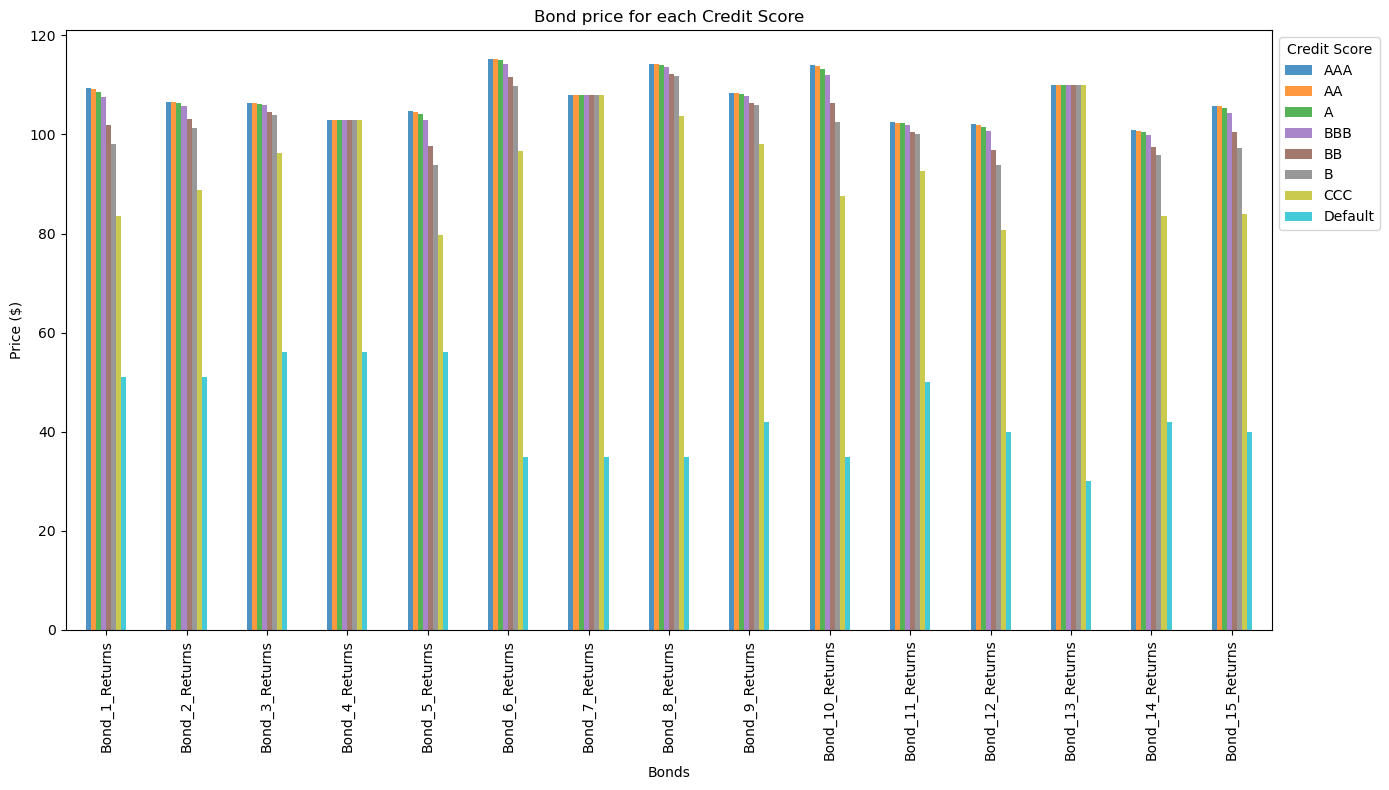

In [33]:
def plot_bond_prices(all_bond_prices_df):
    all_bond_prices_df.T.plot(kind='bar', figsize=(14, 8), alpha=0.8, colormap='tab10')
    plt.title('Bond price for each Credit Score')
    plt.xlabel('Bonds')
    plt.ylabel('Price ($)')
    plt.legend(title='Credit Score', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

plot_bond_prices(all_bond_prices_df)

In [18]:
rows_A = thresholds_df.loc['A']
rows_A_upper = rows_A.copy()
rows_AA = thresholds_df.loc['AA']
rows_AA_upper = rows_AA.copy()
rows_AAA = thresholds_df.loc['AAA']
rows_AAA_upper = rows_AAA.copy()
rows_B = thresholds_df.loc['B']
rows_B_upper = rows_B.copy()
rows_BB = thresholds_df.loc['BB']
rows_BB_upper = rows_BB.copy()
rows_BBB = thresholds_df.loc['BBB']
rows_BBB_upper = rows_BBB.copy()
rows_CCC = thresholds_df.loc['CCC']
rows_CCC_upper = rows_CCC.copy()

rows_A_lower = rows_A.shift(-1, fill_value=-np.inf)
rows_AA_lower = rows_AA.shift(-1, fill_value=-np.inf)
rows_AAA_lower = rows_AAA.shift(-1, fill_value=-np.inf)
rows_B_lower = rows_B.shift(-1, fill_value=-np.inf)
rows_BB_lower = rows_BB.shift(-1, fill_value=-np.inf)
rows_BBB_lower = rows_BBB.shift(-1, fill_value=-np.inf)
rows_CCC_lower = rows_CCC.shift(-1, fill_value=-np.inf)


transition_thresholds = {}

transition_thresholds['AAA'] = {'upper': rows_AAA_upper, 'lower': rows_AAA_lower}
transition_thresholds['AA'] = {'upper': rows_AA_upper, 'lower': rows_AA_lower}
transition_thresholds['A'] = {'upper': rows_A_upper, 'lower': rows_A_lower}
transition_thresholds['BBB'] = {'upper': rows_BBB_upper, 'lower': rows_BBB_lower}
transition_thresholds['BB'] = {'upper': rows_BB_upper, 'lower': rows_BB_lower}
transition_thresholds['B'] = {'upper': rows_B_upper, 'lower': rows_B_lower}
transition_thresholds['CCC'] = {'upper': rows_CCC_upper, 'lower': rows_CCC_lower}

ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC']

transition_thresholds = {}

for initial_rating in ratings:
    rating_thresholds = {}

    upper = globals().get(f'rows_{initial_rating}_upper')  
    lower = globals().get(f'rows_{initial_rating}_lower')  

    for end_rating in ratings:
        upper_bound = upper.loc[end_rating]
        lower_bound = lower.loc[end_rating]

        rating_thresholds[end_rating] = (upper_bound, lower_bound)

    transition_thresholds[initial_rating] = rating_thresholds

rating_mapping = {
    1: 'AAA',
    2: 'AA',
    3: 'A',
    4: 'BBB',
    5: 'BB',
    6: 'B',
    7: 'CCC',
    8: 'Def'
}

bond_data['Rating_(1=AAA,8=Def)'] = bond_data['Rating_(1=AAA,8=Def)'].map(rating_mapping)

In [19]:
def get_final_rating(initial_rating, bond_return, transition_thresholds):
    rating_thresholds = transition_thresholds.get(initial_rating)
    if rating_thresholds is None:
        raise ValueError("Initial rating not found in transition thresholds dictionary")

    for end_rating, (upper_bound, lower_bound) in rating_thresholds.items():
        if lower_bound < bond_return <= upper_bound:
            return end_rating

    return "Default"

final_ratings_df = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)

for column in returns_df.columns:
    bond_id = column.split('_')[1]  
    initial_rating = bond_data.loc[bond_data['issue_id'] == int(bond_id), 'Rating_(1=AAA,8=Def)'].values[0]  # Get initial rating for the bond
    for index, bond_return in enumerate(returns_df[column]):
        final_rating = get_final_rating(initial_rating, bond_return, transition_thresholds)
        final_ratings_df.at[index, column] = final_rating

print("\nFinal Rating based on simulated returns:\n",final_ratings_df)


Final Rating based on simulated returns:
       Bond_1_Returns Bond_2_Returns Bond_3_Returns Bond_4_Returns  \
0                BBB              A             AA            AAA   
1                BBB              A             AA            AAA   
2                BBB              A             AA            AAA   
3                BBB              A             AA            AAA   
4                BBB              A             AA            AAA   
...              ...            ...            ...            ...   
99995            BBB              A             AA            AAA   
99996            BBB              A             AA            AAA   
99997            BBB              A             AA            AAA   
99998             BB              A             AA            AAA   
99999            BBB             BB             AA            AAA   

      Bond_5_Returns Bond_6_Returns Bond_7_Returns Bond_8_Returns  \
0                  A              B              B         

In [20]:
prices_df = pd.DataFrame(index=final_ratings_df.index)

for column in final_ratings_df.columns:
    prices_df[column] = final_ratings_df[column].map(all_bond_prices_df[column])

prices_df['Total_Portfolio_Value'] = prices_df.sum(axis=1)
print("\nSimulated bond prices and total portfolio values based on final rating in $:\n",prices_df)

one_percentile_total_bond_price = (np.percentile(prices_df['Total_Portfolio_Value'], 1)).round(4)

print("\nThe 1% percentile of total bond prices is:$", one_percentile_total_bond_price)
mean_total_bond_price =(prices_df['Total_Portfolio_Value'].mean()).round(4)
print("The mean of the total bond prices is:$",mean_total_bond_price)
Credit_var = (mean_total_bond_price-one_percentile_total_bond_price).round(4)
print("Credit VaR is:$",Credit_var)



Simulated bond prices and total portfolio values based on final rating in $:
        Bond_1_Returns  Bond_2_Returns  Bond_3_Returns  Bond_4_Returns  \
0          107.530944      106.304414       106.30246           103.0   
1          107.530944      106.304414       106.30246           103.0   
2          107.530944      106.304414       106.30246           103.0   
3          107.530944      106.304414       106.30246           103.0   
4          107.530944      106.304414       106.30246           103.0   
...               ...             ...             ...             ...   
99995      107.530944      106.304414       106.30246           103.0   
99996      107.530944      106.304414       106.30246           103.0   
99997      107.530944      106.304414       106.30246           103.0   
99998      102.006386      106.304414       106.30246           103.0   
99999      107.530944      103.151464       106.30246           103.0   

       Bond_5_Returns  Bond_6_Returns  Bond_

## Credit VaR through simulations for the portfolio with all the bonds listed in the xls file ( Recovery rate for each bond is random)

In [21]:
bond_data_path = 'CreditVaR_data.xlsx'
bond_data = pd.read_excel(bond_data_path, sheet_name='bonds')

bond_data.set_index('issue_id', inplace=True)

n_simulations = 100000
corr_matrix = np.array([[1, 0.3, 0.1], [0.3, 1, 0.2], [0.1, 0.2, 1.0]])
factors = np.random.multivariate_normal([0, 0, 0], corr_matrix, size=n_simulations)

for index, row in bond_data.iterrows():
    beta_t = row['Beta_T']
    beta_l = row['Beta_L']
    beta_c = row['Beta_C']
    sigma_epsilon = np.sqrt(
        1 - (beta_t**2 + beta_l**2 + beta_c**2 + 2 * beta_t * beta_l * 0.3 + beta_t * beta_c * 0.1 + beta_l * beta_c * 0.2)
    )
    bond_data.at[index, 'sigma_epsilon'] = sigma_epsilon

In [22]:
def simulate_recovery_rates(bond_data):
    recovery_rates = {}
    for bond_id in bond_data.index:
        alpha, beta = calculate_beta_parameters(bond_data.at[bond_id, 'R_mean'], bond_data.at[bond_id, 'R_std'])
        recovery_rates[bond_id] = np.random.beta(alpha, beta)
    return recovery_rates

def calculate_beta_parameters(mean, std):
    mean_scaled = mean / 100
    std_scaled = std / 100
    alpha = ((1 - mean_scaled) / std_scaled**2 - 1 / mean_scaled) * mean_scaled**2
    beta = alpha * (1 / mean_scaled - 1)
    return alpha, beta

In [23]:
recovery_rates = simulate_recovery_rates(bond_data)

prices_df = pd.DataFrame(index=final_ratings_df.index)

for column in final_ratings_df.columns:
    prices_df[column] = final_ratings_df[column].map(all_bond_prices_df[column])

prices_df['Total_Portfolio_Value'] = prices_df.sum(axis=1)


mapped_bond_prices_df = all_bond_prices_df.iloc[:-1]
for column in final_ratings_df.columns:
    bond_id = int(float(column.split('_')[1])) 
    
    if column in mapped_bond_prices_df.columns:
        prices_df[column] = final_ratings_df[column].map(mapped_bond_prices_df[column])
        
        if prices_df[column].isna().any():
            prices_df[column] = prices_df[column].apply(
                lambda x: 100*np.random.beta(*calculate_beta_parameters(bond_data.at[bond_id, 'R_mean'], bond_data.at[bond_id, 'R_std'])) if pd.isna(x) else x
            )
print("\nFinal ratings based on simualted returns:\n",final_ratings_df)
print("\nFinal bond prices and total portfolio value based on final ratings in $:\n",prices_df.round(4))


Final ratings based on simualted returns:
       Bond_1_Returns Bond_2_Returns Bond_3_Returns Bond_4_Returns  \
0                BBB              A             AA            AAA   
1                BBB              A             AA            AAA   
2                BBB              A             AA            AAA   
3                BBB              A             AA            AAA   
4                BBB              A             AA            AAA   
...              ...            ...            ...            ...   
99995            BBB              A             AA            AAA   
99996            BBB              A             AA            AAA   
99997            BBB              A             AA            AAA   
99998             BB              A             AA            AAA   
99999            BBB             BB             AA            AAA   

      Bond_5_Returns Bond_6_Returns Bond_7_Returns Bond_8_Returns  \
0                  A              B              B        

In [24]:
one_percentile_total_bond_price = (np.percentile(prices_df['Total_Portfolio_Value'], 1)).round(4)

print("\nThe 1% percentile of total bond prices is:$", one_percentile_total_bond_price)
mean_total_bond_price = (prices_df['Total_Portfolio_Value'].mean()).round(4)

print("The mean of the total bond prices is:$",mean_total_bond_price)
Credit_var = (mean_total_bond_price-one_percentile_total_bond_price).round(4)
print("Credit VaR is:$",Credit_var)


The 1% percentile of total bond prices is:$ 1346.8814
The mean of the total bond prices is:$ 1541.9606
Credit VaR is:$ 195.0792
